In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

In [230]:
filepath_train_2021 = 'Data_2021.txt'
filepath_train_2022 = 'Data_2022.txt'
filepath_train_2023 = 'Data_2023.txt'
filepath_test_2024 = 'Data_2024.txt'

# Define column names once
colnames = ["YY","MM","DD","hh","mm","WDIR","WSPD","GST","WVHT","DPD","APD","MWD",
            "PRES","ATMP","WTMP","DEWP","VIS","TIDE"]

# Load all training years
data_2021 = pd.read_csv(filepath_train_2021, sep=r'\s+', comment='#', header=None)
data_2022 = pd.read_csv(filepath_train_2022, sep=r'\s+', comment='#', header=None)
data_2023 = pd.read_csv(filepath_train_2023, sep=r'\s+', comment='#', header=None)

for df in [data_2021, data_2022, data_2023]:
    df.columns = colnames
    # Replace missing values
    df.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan}, inplace=True)
    # Drop rows without wave height
    df.dropna(subset=["WVHT"], inplace=True)
    # Interpolate
    df.interpolate(inplace=True)
    df.bfill(inplace=True)
    df.ffill(inplace=True)
    # Datetime
    df["datetime"] = pd.to_datetime(
        df[['YY','MM','DD','hh','mm']].rename(
            columns={'YY':'year','MM':'month','DD':'day','hh':'hour','mm':'minute'}
        )
    )
    df.drop(columns=["YY","MM","DD","hh","mm","VIS","TIDE"], inplace=True)
    # Cyclical features
    df["hour_sin"] = np.sin(2*np.pi*df["datetime"].dt.hour / 24)
    df["hour_cos"] = np.cos(2*np.pi*df["datetime"].dt.hour / 24)
    df["doy_sin"]  = np.sin(2*np.pi*df["datetime"].dt.dayofyear / 365)
    df["doy_cos"]  = np.cos(2*np.pi*df["datetime"].dt.dayofyear / 365)
    df.drop(columns=["datetime"], inplace=True)

data_train = pd.concat([data_2021, data_2022, data_2023], ignore_index=True)
data_test = pd.read_csv(filepath_test_2024, sep=r'\s+', comment='#', header=None)
data_test.columns = colnames

# Replace missing values with NaNs
data_train= data_train.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan})
data_test= data_test.replace({99.00: np.nan, 99.0: np.nan, 999: np.nan, 999.0: np.nan})
# Drop rows without wave height
data_train= data_train.dropna(subset=["WVHT"])
data_test= data_test.dropna(subset=["WVHT"])
# Interpolate to fill in any remaining NaNs
data_train= data_train.interpolate().bfill().ffill()
data_test= data_test.interpolate().bfill().ffill()

data_test["datetime"]= pd.to_datetime(data_test[['YY','MM','DD','hh','mm']].rename(columns=
        {'YY':'year','MM':'month','DD':'day','hh':'hour','mm':'minute'}))
data_test= data_test.drop(columns=["YY","MM","DD","hh","mm","VIS","TIDE"])

data_test["hour_sin"] = np.sin(2*np.pi*data_test["datetime"].dt.hour / 24)
data_test["hour_cos"] = np.cos(2*np.pi*data_test["datetime"].dt.hour / 24)
data_test["doy_sin"]  = np.sin(2*np.pi*data_test["datetime"].dt.dayofyear / 365)
data_test["doy_cos"]  = np.cos(2*np.pi*data_test["datetime"].dt.dayofyear / 365)
data_test= data_test.drop(columns=["datetime"])

Featurs to Use:
WSPD
GST
WDIR
PRES
ATMP
WTMP
DEWP
hour_sin
Hour_cos
doy_sin
doy_cos

Exclude:
DPD
MWD
APD

Target
WVHT

In [231]:
features = ["WSPD","GST","WDIR","PRES","ATMP","WTMP","DEWP",
            "hour_sin","hour_cos","doy_sin","doy_cos"]

X_train = data_train[features].values
y_train = data_train["WVHT"].values.reshape(-1, 1)

X_test = data_test[features].values
y_test = data_test["WVHT"].values.reshape(-1, 1)

# --- Normalize using scalers fit on training data ---
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled  = x_scaler.transform(X_test)   # transform with same scaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)   # transform with same scaler

# Wrap back into pandas for consistency
X_train_df = pd.DataFrame(X_train_scaled, columns=features)
y_train_series = pd.Series(y_train_scaled.flatten(), name="WVHT")

X_test_df = pd.DataFrame(X_test_scaled, columns=features)
y_test_series = pd.Series(y_test_scaled.flatten(), name="WVHT")

In [232]:
def create_window(x, y, time_steps=72):
    x_window, y_window = [], []
    for i in range(len(x) - time_steps):
        x_window.append(x.iloc[i:(i+time_steps)].values)
        y_window.append(y.iloc[i+time_steps])
    return np.array(x_window), np.array(y_window)

X_train_window, y_train_window = create_window(X_train_df, y_train_series, time_steps=72)
X_test_window, y_test_window   = create_window(X_test_df, y_test_series, time_steps=72)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, 64), # going from 32 to 64 because of nonlinear relationship with hidden states to eave height
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        out, _ = self.lstm(x)
        # use last time-step features for prediction
        last_feat = out[:, -1, :]           # (batch, hidden_dim)
        yhat = self.head(last_feat)         # (batch, output_dim)
        return yhat

In [234]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32
num_epochs = 100
input_dim = 11
hidden_dim = 32     # 32, 64, 128
num_layers = 3
dropout = 0.3
learning_rate = 0.001

cuda


In [235]:
# Define model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, output_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert windowed data into tensors
X_train_tensor = torch.tensor(X_train_window, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_window, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test_window, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_window, dtype=torch.float32).to(device)

In [236]:
train_hist = np.zeros(num_epochs)
test_hist  = np.zeros(num_epochs)

best_test_loss = float("inf")
best_epoch = -1

for t in range(num_epochs):
    # ---- Training ----
    model.train()
    y_pred = model(X_train_tensor)                  # shape: (num_samples, 1)
    train_loss = criterion(y_pred, y_train_tensor.view(-1, 1))  # ensure shape match
    train_hist[t] = train_loss.item()

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor)          # shape: (num_samples, 1)
        test_loss = criterion(y_test_pred, y_test_tensor.view(-1, 1))
        test_hist[t] = test_loss.item()

    # ---- Track best model ----
    if test_loss.item() < best_test_loss:
        best_test_loss = test_loss.item()
        best_epoch = t + 1
        torch.save(model.state_dict(), "best_model.pth")  # save parameters
        print(f"New best model saved at epoch {best_epoch} with Test MSE: {best_test_loss:.4f}")

    print(f"Epoch {t+1}/{num_epochs}, "
          f"Train MSE: {train_loss.item():.4f}, "
          f"Test MSE: {test_loss.item():.4f}")


New best model saved at epoch 1 with Test MSE: 0.9366
Epoch 1/100, Train MSE: 1.0057, Test MSE: 0.9366
New best model saved at epoch 2 with Test MSE: 0.9320
Epoch 2/100, Train MSE: 1.0027, Test MSE: 0.9320
New best model saved at epoch 3 with Test MSE: 0.9276
Epoch 3/100, Train MSE: 1.0000, Test MSE: 0.9276
New best model saved at epoch 4 with Test MSE: 0.9233
Epoch 4/100, Train MSE: 0.9975, Test MSE: 0.9233
New best model saved at epoch 5 with Test MSE: 0.9190
Epoch 5/100, Train MSE: 0.9949, Test MSE: 0.9190
New best model saved at epoch 6 with Test MSE: 0.9146
Epoch 6/100, Train MSE: 0.9923, Test MSE: 0.9146
New best model saved at epoch 7 with Test MSE: 0.9100
Epoch 7/100, Train MSE: 0.9892, Test MSE: 0.9100
New best model saved at epoch 8 with Test MSE: 0.9053
Epoch 8/100, Train MSE: 0.9860, Test MSE: 0.9053
New best model saved at epoch 9 with Test MSE: 0.9002
Epoch 9/100, Train MSE: 0.9823, Test MSE: 0.9002
New best model saved at epoch 10 with Test MSE: 0.8944
Epoch 10/100, Trai

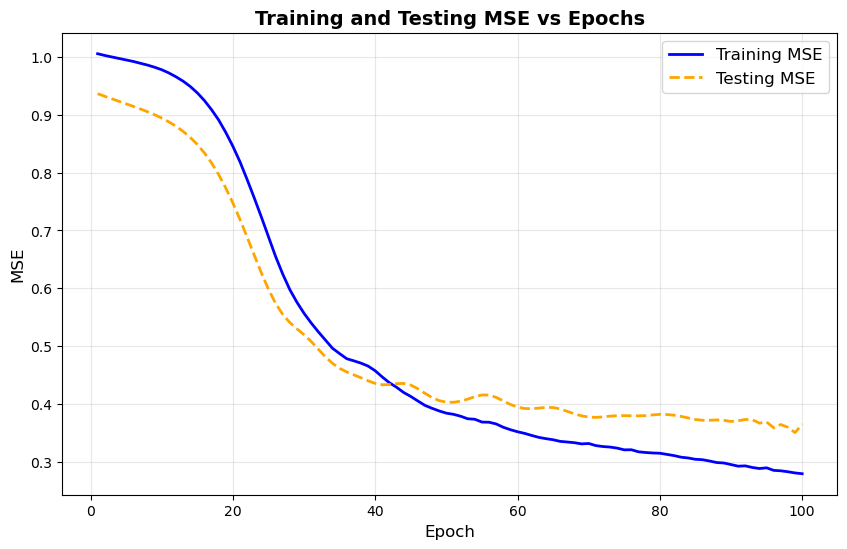

In [237]:
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), train_hist, label='Training MSE', color='blue', linewidth=2)
plt.plot(range(1, num_epochs+1), test_hist, label='Testing MSE', color='orange', linestyle='--', linewidth=2)

plt.title('Training and Testing MSE vs Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

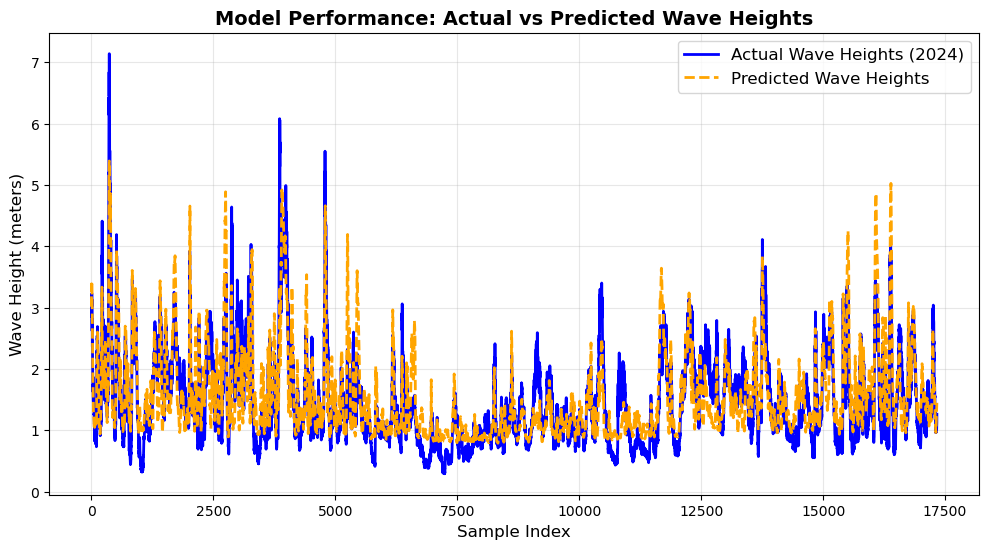

In [238]:
# Convert tensors to numpy
y_true = y_test_tensor.cpu().numpy()
y_pred = y_test_pred.cpu().detach().numpy()

# Ensure both are column vectors
y_true = y_true.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# Inverse-transform to physical units (meters)
y_true_rescaled = y_scaler.inverse_transform(y_true).flatten()
y_pred_rescaled = y_scaler.inverse_transform(y_pred).flatten()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_true_rescaled, label='Actual Wave Heights (2024)', color='blue', linewidth=2)
plt.plot(y_pred_rescaled, label='Predicted Wave Heights', color='orange', linestyle='--', linewidth=2)

plt.title("Model Performance: Actual vs Predicted Wave Heights", fontsize=14, fontweight='bold')
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("Wave Height (meters)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [242]:
best_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout, output_dim=1).to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

with torch.no_grad():
    y_test_pred = best_model(X_test_tensor)  # shape: (num_samples, 1)
    test_loss = criterion(y_test_pred, y_test_tensor.view(-1, 1))

print(f"Best saved model Test MSE: {test_loss.item():.4f}")
print(f"Accuracy of: {np.sqrt(test_loss.item()):.2f} meters")


Best saved model Test MSE: 0.3503
Accuracy of: 0.59 meters
